# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.0


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l data

total 6632
-rw-r--r-- 1 torak28 torak28 1076355 Oct 18 12:15 easy.csv
-rw-r--r-- 1 torak28 torak28 2924235 Oct 18 12:15 hard.csv
-rw-r--r-- 1 torak28 torak28 2787990 Oct 18 12:15 medium.csv


In [4]:
df = pd.read_csv("data//easy.csv")

In [5]:
df.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,Car
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,Car
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,Car


In [6]:
'''
Wygląd danych:

|     Nazwa     | Ilość pól |
| :-----------: | :-------: |
|     time      |     1     |
| accelerometer |     4     |
|   gyroscope   |     4     |
|     sound     |     4     |
|    target     |     1     |

Suma: 14

'''


df.shape

(5893, 14)

# Obróbka danych

In [7]:
'''
Zmiana targetu na liczby:

0 - Still
1 - Car
2 - Train
3 - Bus
4 - Walking
'''
df.target.unique()

array(['Still', 'Car', 'Train', 'Bus', 'Walking'], dtype=object)

In [8]:
df = df.replace({'target':'Still'},{'target':0})
df = df.replace({'target':'Car'},{'target':1})
df = df.replace({'target':'Train'},{'target':2})
df = df.replace({'target':'Bus'},{'target':3})
df = df.replace({'target':'Walking'},{'target':4})

In [9]:
'''
Podział danych z całego df na X i y:

X - wszystko oprócz targetu(time, accelerometer,gyroscope, sound) 
y - target
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [10]:
df.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,0
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,1
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,0
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,1
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,1


# Podział na dane testowe i treningowe

In [11]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(4714)
test  - 20% danych(1179)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

'''
Podział na X_train, y_train, X_test, y_test

X_train, X_test - bez 'targetu'
y_train, y_test - sam 'target' dla X_train, X_test
'''
X_train = train.drop('target', axis = 1)
y_train = train.target

X_test = test.drop('target', axis = 1)
y_test = test.target

In [12]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4714, 13)
	 y_train: (4714,)
	 X_test: (1179, 13)
	 y_test: (1179,)


In [13]:
# Konwersja danych z pandas dataframe do numpy

df = df.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [14]:
# Upewnienie się że dane w X_train i X_test są floatem - lepsze dla klasyfikatora

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [15]:
num_classes = 5

# Potrzebne na przysłość - zapis dla macierzy konfuzji
y_test_sav = y_test

# Zamiana wpisu z [1] na [0, 1, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
# Upewnienie się że dane w y_train i y_test są floatem - lepsze dla klasyfikatora

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [17]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4714, 13)
	 y_train: (4714, 5)
	 X_test: (1179, 13)
	 y_test: (1179, 5)


# Funkcję liczące statystyki

In [18]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [19]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [20]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [21]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Model

In [22]:
# Stałe do monitorowania pracy modelu

epochs = 50
batch_size = 10
validation_steps = 200, #test.shape[0]//batch_size,
steps_per_epoch = 200, #train.shape[0]//batch_size,
optimizer = 'adam'
loss_type = 'categorical_crossentropy'
LSTM_size = 128

In [23]:
model = Sequential()
model.add(Embedding(X_train.shape[0], X_train.shape[1]))
model.add(LSTM(LSTM_size))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 13)          61282     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 134,631
Trainable params: 134,631
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
#                     validation_steps=validation_steps,
                    epochs=epochs,
#                     steps_per_epoch=steps_per_epoch,
                    batch_size=batch_size, 
                    callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis do nowego pliku
model.save('the_best.h5')

/home/torak28/Desktop/Studia/Auto-Tag/datamining/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4714 samples, validate on 1179 samples
Epoch 1/50
4714/4714 [==============================] - 5s 1ms/step - loss: 1.2443 - accuracy: 0.4631 - get_f1: 0.2890 - val_loss: 1.0764 - val_accuracy: 0.5522 - val_get_f1: 0.4316

Epoch 00001: val_loss improved from inf to 1.07641, saving model to best.h5
Epoch 2/50
4714/4714 [==============================] - 5s 1ms/step - loss: 1.0659 - accuracy: 0.5613 - get_f1: 0.4587 - val_loss: 1.0134 - val_accuracy: 0.5759 - val_get_f1: 0.5168

Epoch 00002: val_loss improved from 1.07641 to 1.01341, saving model to best.h5
Epoch 3/50
4714/4714 [==============================] - 5s 1ms/step - loss: 0.9917 - accuracy: 0.5840 - get_f1: 0.5013 - val_loss: 0.9890 - val_accuracy: 0.5861 - val_get_f1: 0.4912

Epoch 00003: val_loss improved from 1.01341 to 0.98897, saving model to best.h5
Epoch 4/50
4714/4714 [==============================] - 5s 1ms/step - loss: 0.9318 - accuracy: 0.6154 - get_f1: 0.5462 - val_loss: 1.0170 - val_accuracy: 0.5861 - val_

# Statystyki

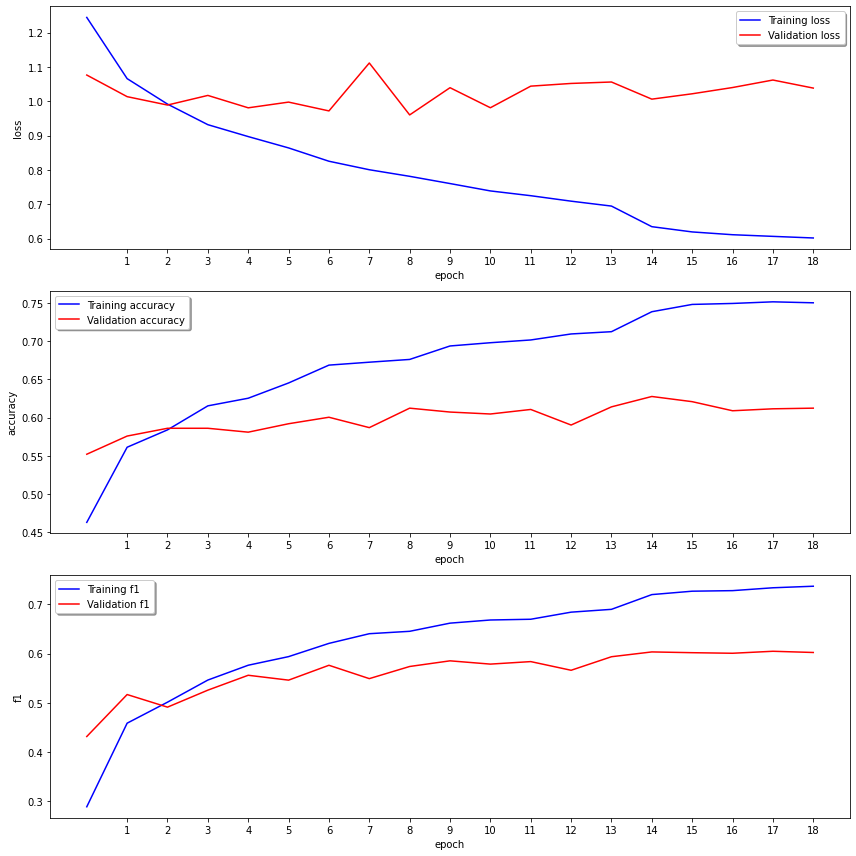

Test loss: 0.96
Test accuracy: 0.612
Test F1: 0.578


In [25]:
loss, accuracy, get_f1  = model.evaluate(X_test, y_test, verbose=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(1, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(1, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(1, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')


In [26]:
predictions = model.predict(X_test)

In [27]:
predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x)), predictions)))
predictions = numpy.reshape(predictions, (1179,))

In [28]:
ConfusionMatrixY = y_test_sav
ConfusionMatrixYpred = predictions

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea2c025e80>)

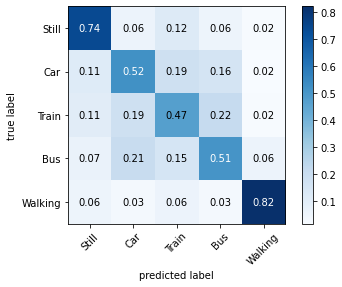

In [29]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(ConfusionMatrixY, ConfusionMatrixYpred)

plot_confusion_matrix(conf_mat=cm,
                      colorbar=True, 
                      show_absolute=False,
                      show_normed=True,
                      class_names=['Still', 'Car', 'Train', 'Bus', 'Walking'])

In [30]:
print(cm)

[[175  15  28  13   5]
 [ 27 123  44  38   4]
 [ 25  44 111  51   5]
 [ 16  49  36 120  15]
 [ 13   7  15   7 193]]


In [31]:
accuracy, precision, recall, fscore = countStats(ConfusionMatrixY, ConfusionMatrixYpred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.6123833757421544
Precision: 0.6134123439999016
Recall: 0.6123833757421544
F-score: 0.612498843707649
